In [ ]:
import sys
sys.path.append('../../timmy-lite')
from timmy.multicolor import get_delta_obs_given_mstars

import numpy as np
import chronos as cr
import pandas as pd
from tqdm import tqdm

In [ ]:
m2,m3 = 0.1, 0.1
delta_obs_dict = get_delta_obs_given_mstars(m2, m3, 
                                            mstar1=0.3, teff1=3300, rstar1=0.3,
                                            age='5.0e+09', verbose=False)

for d in delta_obs_dict:
    print(f"{d}: {delta_obs_dict[d]:.4f}")

In [ ]:
from uncertainties import ufloat

depth_tess = ufloat(0.1048, 0.0073)**2
depth_M2g = ufloat(0.0988, 0.0075)**2
depth_M2z = ufloat(0.0984, 0.0038)**2

In [ ]:
imp_pars = [0,0.99]
obs_depths = {'TESS': depth_tess, 
              'MuSCAT_gp2': depth_M2g, 
              'MuSCAT_zs2': depth_M2z, 
             }

obs_tshapes = {}
for imp_par in imp_pars:
    obs_tshape = {}
    for key in obs_depths.keys():
        rprs = obs_depths[key]**0.5
        obs_tshape[key] = cr.transit.tshape_approx(rprs.nominal_value, b=imp_par)
    obs_tshapes[imp_par] = obs_tshape

In [ ]:
obs_depths

In [ ]:
obs_tshapes

In [4]:
bp1, bp2 = 'MuSCAT_gp2', 'MuSCAT_zs2'
m2s = np.linspace(0.1,0.4,20)
m3s = m2s.copy()

mass_grids = {}
masked_grids = {}
for imp_par in imp_pars:
    mass_grid1 = np.zeros((len(m3s), len(m2s)))
    mass_grid1[:] = np.nan #replace zeros with NaN
    mass_grid2 = mass_grid1.copy()
    
    masked_grid1 = np.zeros((len(m3s), len(m2s)))
    masked_grid1[:] = False
    mass_grid2 = mass_grid1.copy()
    
    mass_grids[imp_par] = {}
    masked_grids[imp_par] = {}
    for i,m2 in tqdm(enumerate(m2s)):
        for j,m3 in enumerate(m3s):
            if m2>=m3:
                d = get_delta_obs_given_mstars(m2, m3, imp_par=imp_par, verbose=False)
                mass_grid1[j,i] = d[bp1]                
                mass_grid2[j,i] = d[bp2]
    mass_grids[imp_par][bp1] = mass_grid1
    mass_grids[imp_par][bp2] = mass_grid2
    
    #masked
    depth1 = obs_depths[bp1]
    rtol1 = depth1.std_dev/depth1.nominal_value
    idx1 = np.isclose(mass_grid1, depth1.nominal_value, atol=rtol1)
    masked_grids[imp_par][bp1] = np.ma.array(mass_grid1, mask=~idx1)
    
    depth2 = obs_depths[bp2]
    rtol2 = depth2.std_dev/depth2.nominal_value
    idx2 = np.isclose(mass_grid2, depth2.nominal_value, atol=rtol2)
    masked_grids[imp_par][bp2] = np.ma.array(mass_grid2, mask=~idx2)

NameError: name 'imp_pars' is not defined

In [17]:
import matplotlib.pyplot as pl
import matplotlib.colors as mcolors

class MidPointLogNorm(mcolors.LogNorm):
    """
    Log normalization with midpoint offset

    from
    https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
    """

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        mcolors.LogNorm.__init__(self, vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint = midpoint

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = (
            [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)],
            [0, 0.5, 1],
        )
        return np.ma.masked_array(np.interp(np.log(value), x, y))
    
def plot_grid(mass_grid, m2s, m3s, 
              cmap="default", 
              use_norm_cbar=False, 
              use_log_cbar=False,
              reference=None,
              cbar_label="", 
              cbar_shrink=0.9,
              aspect_ratio=1,
              ax=None
             ):
    """
    Parameters
    ----------
    mass_grid : 2-d array
        mass grid
    """
    if ax is None:
        fig, ax = pl.subplots(1, 1, figsize=(8, 8))
    xmin, xmax = m2s[0], m2s[-1]
    ymin, ymax = m3s[0], m3s[-1]

    vmin, vmax = np.nanmin(mass_grid), np.nanmax(mass_grid)
    if use_log_cbar:
        assert reference is not None
        norm = MidPointLogNorm(
           vmin=vmin, vmax=vmax, midpoint=reference
        )
    elif use_norm_cbar:
        assert reference is not None
        norm=mcolors.TwoSlopeNorm(vmin=vmin, vcenter=reference, vmax=vmax)
    else:
        norm=None
    # plot matrix
    cbar = ax.imshow(
        mass_grid,
        origin="lower",
        interpolation="none",
        extent=[xmin, xmax, ymin, ymax],
        cmap=cmap,
        norm=norm
    )
    pl.colorbar(
        cbar, ax=ax, label=label, 
        orientation="vertical", shrink=cbar_shrink,
    )

    # add labels
    ax.set_aspect(aspect_ratio)
    pl.setp(
        ax,
        xlim=(xmin, xmax),
        ylim=(ymin, ymax),
        xlabel="Secondary star mass ($M_{\odot}$)",
        ylabel="Tertiary star mass ($M_{\odot}$)",
    )
#     ax.set_title(label)
    return ax

In [18]:
pl.style.use("default")
pl.rcParams['font.size'] = 16
pl.rcParams['figure.dpi'] = 100

<a list of 7 text.Text objects>

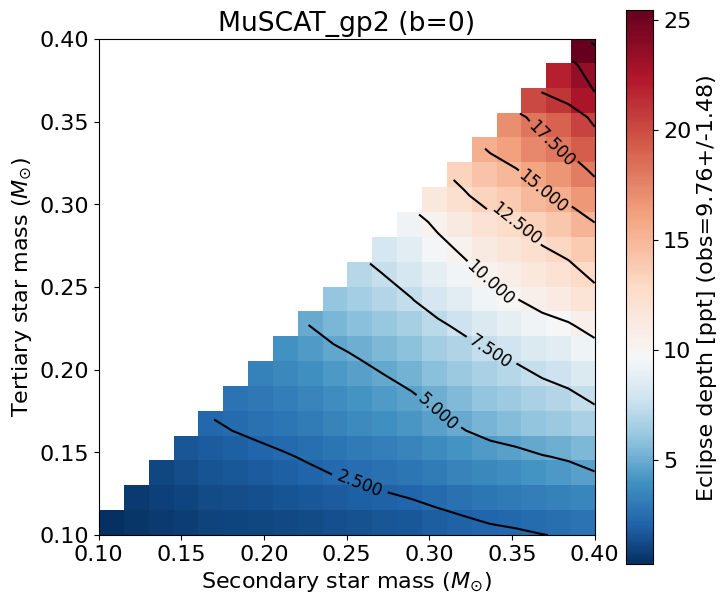

In [21]:
imp_par = 0
factor = 1e3
depth = obs_depths[bp1]
grid = masked_grids[imp_par][bp1]
label = f'Eclipse depth [ppt] (obs={depth*factor:.2f})'
ax = plot_grid(grid*1e3, 
                m2s, m3s, 
                cmap="RdBu_r", 
                use_norm_cbar=True, 
                use_log_cbar=False,
                reference=depth.nominal_value*factor,         
                cbar_label=label, 
                aspect_ratio=1,
               )
ax.set_title(f"{bp1} (b={imp_par})")

contours = ax.contour(m2s, m3s, grid*factor, 10, colors='black');
ax.clabel(contours, inline=True, fontsize=12)

In [1]:
imp_par = 0
grid = mass_grids[imp_par][bp1]
depth = obs_depths[bp1]
label = f'Eclipse depth [ppt] (obs={depth*factor:.2f})'

fig, axs = pl.subplots(1, 2, figsize=(16, 8))

for n,imp_par in enumerate([0,0.99]):
    ax = axs[n]
    grid = mass_grids[imp_par][bp1]
    _ = plot_grid(grid*1e3, 
                    m2s, m3s, 
                    cmap="RdBu_r", 
                    use_norm_cbar=True, 
                    use_log_cbar=False,
                    reference=depth.nominal_value*1e3,         
                    cbar_label=label, 
                    aspect_ratio=1,
                    ax=ax
                   )
    ax.set_title(f"{bp1} (b={imp_par})")
    
    contours = ax.contour(m2s, m3s, grid*1e3, 10, colors='black');
    ax.clabel(contours, inline=True, fontsize=14)

NameError: name 'mass_grids' is not defined

In [ ]:
fig.savefig('../figures/heb_tess.png', bbox_inches='tight')

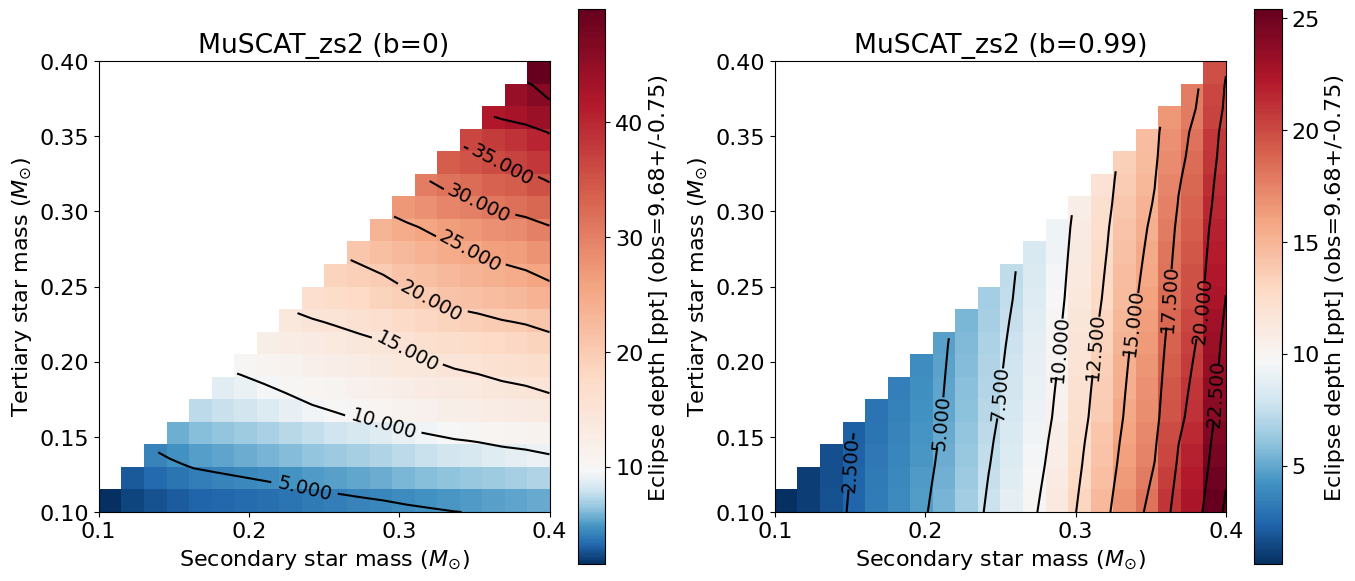

In [24]:
depth = obs_depths[bp2]
label = f'Eclipse depth [ppt] (obs={depth*factor:.2f})'

fig, axs = pl.subplots(1, 2, figsize=(16, 8))

for n,imp_par in enumerate([0,0.99]):
    ax = axs[n]
    grid = mass_grids[imp_par][bp2]
    _ = plot_grid(grid*1e3, 
                    m2s, m3s, 
                    cmap="RdBu_r", 
                    use_norm_cbar=True, 
                    use_log_cbar=False,
                    reference=depth.nominal_value*1e3,         
                    cbar_label=label, 
                    aspect_ratio=1,
                    ax=ax
                   )
    ax.set_title(f"{bp2} (b={imp_par})")
    contours = ax.contour(m2s, m3s, grid*1e3, 10, colors='black');
    ax.clabel(contours, inline=True, fontsize=14)